# Определение возраста покупателей

Задача проекта состоит в построении сверточной нейросети для определения возраста по фотографии. Это можжно будет использовать для подготовки предложений покупателям, или для проверки честности кассиров при продаже товаров с возрастным ограничением.

## Исследовательский анализ данных

# Загрузка данных

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [7]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [8]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Размер выборки достаточен, чтобы не делать заморозку весов.

Вообще выборка достаточна, чтобы сделать общее исследование. Но если рассматривать конкретные возраста, то можно было бы попробовать и увеличить выборку.

<AxesSubplot:>

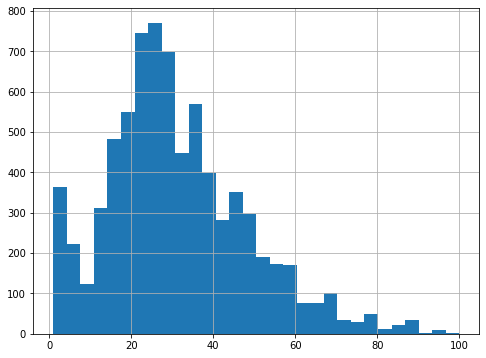

In [9]:
# распределние возрастов
labels['real_age'].hist(figsize=[8,6], bins=30)


Можно было бы сказать, что на гистограмме нормальное распределение возрастов, только есть локальный максимум около 0 - много фоток маленьких детей, как в жизни. Возможно, стоило бы увеличить количество подростков через апсемплинг или аугментацию, для увеличения точности их определения, ведь задача стоит различить возраст совершеннолетия.

In [10]:
train_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [12]:
imgs = next(train_gen_flow)

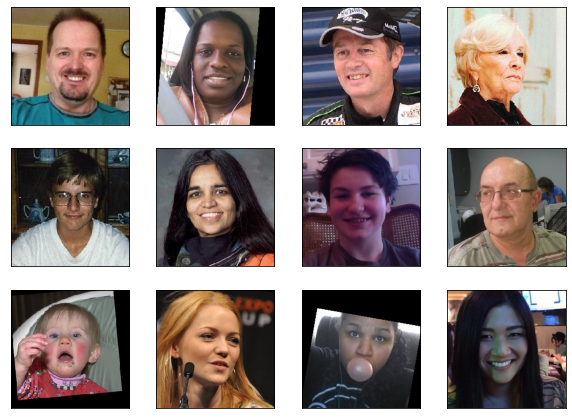

In [13]:
fig = plt.figure(figsize=[10,10])
for i in range(12):
    fig.add_subplot(4,4,i+1)
    plt.imshow(imgs[0][i])
    plt.xticks([])
    plt.yticks([])


Фотографии цветные, три канала. Есть странные фотки. Некоторые фотографии повернуты неправильно, можно было бы при аугментации сделать повороты. Но я не стал.

Задача регрессии требует, чтобы в результате было число (сколько лет человеку).

При загрузке сделаем аугментацию, для улучшения предсказаний. Будем использовать ResNet50 с весами ImageNet без вершины, на входе будут изображения 224х224х3, на выходе будет слой GlobalAveragePooling2D и 1 нейрон с активацией ReLu. Функция потерь MSE.

## Обучение модели

### Код обучения модели.

Выполнен отдельно.

```python

import numpy as np
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

def load_train(path):

    labels = pd.read_csv(path + 'labels.csv')
    
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255,
        horizontal_flip=True,
        vertical_flip=True,
        width_shift_range=0.2,
        height_shift_range=0.2
        )
        
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
        
    return train_gen_flow

def load_test(path):

    labels = pd.read_csv(path + 'labels.csv')
    
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255,
        )
        
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
        
    return test_gen_flow

def create_model(input_shape):

    optimizer = Adam(lr=0.0001)

    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top=False) 

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))

    model.compile(
        optimizer=optimizer,
        loss='mean_squared_error',
        metrics=['mae']
        )
    return model



def train_model(model, train_data, test_data, batch_size=None, epochs=7,
               steps_per_epoch=None, validation_steps=None):
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    
    model.fit(
        train_data, 
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2)

    return model 

```

### Результат обучения.

```

2023-06-01 18:34:58.958899: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-06-01 18:34:58.958947: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2023-06-01 18:34:58.958956: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2023-06-01 18:34:58.962704: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-06-01 18:34:58.962751: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 10240 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/7
2023-06-01 18:35:09.371443: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-06-01 18:35:09.792229: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 97s - loss: 266.2966 - mae: 11.9350 - val_loss: 736.2572 - val_mae: 22.1883
Epoch 2/7
178/178 - 98s - loss: 117.6892 - mae: 8.1477 - val_loss: 670.8822 - val_mae: 20.9401
Epoch 3/7
178/178 - 100s - loss: 96.5529 - mae: 7.4320 - val_loss: 311.3159 - val_mae: 13.0513
Epoch 4/7
178/178 - 100s - loss: 83.1680 - mae: 6.9123 - val_loss: 129.7778 - val_mae: 8.6498
Epoch 5/7
178/178 - 104s - loss: 75.6320 - mae: 6.6415 - val_loss: 98.9383 - val_mae: 7.3513
Epoch 6/7
178/178 - 104s - loss: 67.0442 - mae: 6.2329 - val_loss: 91.4974 - val_mae: 7.2214
Epoch 7/7
178/178 - 99s - loss: 60.5986 - mae: 5.9375 - val_loss: 83.8747 - val_mae: 6.8470
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 83.8747 - mae: 6.8470
Test MAE: 6.8470

```

## Анализ обученной модели

Сравним со случайной моделью, для этого используем итератор из теста.

In [14]:
path='/datasets/faces/'

test_datagen = ImageDataGenerator(
    validation_split=0.25,
    rescale=1./255,
    )

test_gen_flow = test_datagen.flow_from_dataframe(
    dataframe=labels,
    directory=path + 'final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    subset='validation',
    seed=12345)

Found 1897 validated image filenames.


In [15]:
# достанем все таргеты из итератора
all_target = np.array([])
for i in range(len(test_gen_flow)):
    all_target=np.concatenate((all_target, test_gen_flow[i][1]))

In [16]:
# сгенерим случайные предсказания
predict = np.random.randint(1, 100, len(all_target))
len(predict)

1897

In [17]:
#mse = np.mean((predict - all_target) ** 2)
#print('MSE случайной модели: %f' %mse)

In [18]:
mae = np.mean(np.abs(predict - all_target))
print('MAE случайной модели: %f' %mae)

MAE случайной модели: 31.836584


# Вывод

Мы создали модель для магазина, которая может определять возраст человека по фотографии лица. Получен большой набор цветных фотографий людей разных возрастов, обучена модель на основе реснет50 с метрикой MAE = 6.847, что довольно близко к тем, что можно получить на этом наборе изображений.

С точки зрения заказчика, ошибка на 7 лет может быть значительна, 11-летний не должен быть принят за совершеннолетнего. Но и 17-летний тоже не должен. Можно предположить, что модель подтверждает известное явление, что люди часто выглядят не на свой возраст. Определение возраста меньше чем 25 лет дает сигнал, что нужно проверить документы.

Зато такая модель могла бы подойти для рекомендации товаров, популярных у определенных возрастных групп. 

Что касается более четкого определения совершеннолетия, то тут рационально будет рассмотреть, например, такие варианты:
    
    1) Расширить выборку по подросткам новыми данными. При невозможности получения новых данных применить аугментацию.
    2) Подойти с другой стороны и попробовать сделать бинарный классификатор "не_совершеннолетний/совершеннолетний" и оценивать уже точность классификации, а не точность определения всех возрастных групп.
    3) Сделать сеть, которую обучить только на возрастах около 10-25 лет. Если она получится достаточно точной, отправлять на "дооценку" фото, которые основная сеть определила как принадлежащие к этому возрастному диапазону.